<a href="https://colab.research.google.com/github/btbcy/HYLee_ML_HW/blob/master/hw3_keras_tpu_experimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip # 下載資料集

Downloading...
From: https://drive.google.com/uc?id=19CzXudqN58R3D-1G8KeFWk8UDQwlb8is
To: /content/food-11.zip
1.16GB [00:05, 195MB/s]


In [ ]:
# import os
# os.chdir("gdrive/My Drive/Colab Notebooks/Hung-yi Lee HW/HW3_CNN") #更改路徑
# os.getcwd() #查看當前路徑

# unzip

In [2]:
!unzip -q food-11.zip

In [ ]:
# zip_path = 'gdrive/My Drive/Colab Notebooks/Hung-yi Lee HW/HW3_CNN/food-11.zip'
!cp 'gdrive/My Drive/Colab Notebooks/Hung-yi Lee HW/HW3_CNN/food-11.zip' .
!unzip -q food-11.zip
!rm food-11.zip

# import

In [46]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
print("tf.data.experimental.AUTOTUNE = {}".format(AUTO))

Tensorflow version 2.3.0
tf.data.experimental.AUTOTUNE = -1


# TPU

In [5]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.20.111.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.20.111.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


# read data

In [6]:
def readfile(path, label):
    # label 是一個 boolean variable，代表需不需要回傳 y 值
    image_dir = sorted(os.listdir(path))
    # x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.float32)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        x[i, :, :] = cv2.resize(img,(128, 128)) * 1.0 / 255.0
        # do normalization on augmentation
        # x[i, :, :] = cv2.resize(img,(128, 128))
        if label:
          # keras.utils.to_categorical(int(file.split("_")[0]), num_classes=11)
          y[i] = int(file.split("_")[0])
    if label:
      return x, y
    else:
      return x

In [7]:
# 分別將 training set、validation set、testing set 用 readfile 函式讀進來
workspace_dir = './food-11'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(os.path.join(workspace_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


## test data

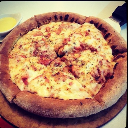

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(train_x[1]*255)

In [ ]:
train_x[1]

array([[[0.03137255, 0.01568628, 0.01960784],
        [0.02352941, 0.01176471, 0.01176471],
        [0.01568628, 0.00784314, 0.00784314],
        ...,
        [0.03921569, 0.01176471, 0.00784314],
        [0.        , 0.00392157, 0.        ],
        [0.01960784, 0.        , 0.00784314]],

       [[0.03137255, 0.05490196, 0.03529412],
        [0.5058824 , 0.54901963, 0.5137255 ],
        [0.58431375, 0.6313726 , 0.5921569 ],
        ...,
        [0.02745098, 0.03529412, 0.04313726],
        [0.        , 0.00784314, 0.00784314],
        [0.01960784, 0.        , 0.00392157]],

       [[0.61960787, 0.6901961 , 0.6392157 ],
        [0.6117647 , 0.6862745 , 0.63529414],
        [0.60784316, 0.6901961 , 0.6313726 ],
        ...,
        [0.35686275, 0.34117648, 0.3529412 ],
        [0.02352941, 0.00784314, 0.01176471],
        [0.01176471, 0.        , 0.        ]],

       ...,

       [[0.11372549, 0.01176471, 0.3764706 ],
        [0.11372549, 0.01960784, 0.36078432],
        [0.11764706, 0

## preprocessing

In [8]:
# # Normalize pixel values to be between 0 and 1
# train_x = train_x / 255
# val_x = val_x / 255
# test_x = test_x / 255

# Converts a class vector (integers) to binary class matrix.
train_y = keras.utils.to_categorical(train_y, num_classes=11)
val_y = keras.utils.to_categorical(val_y, num_classes=11)

index = np.arange(len(train_x))
np.random.shuffle(index)
train_x = train_x[index]
train_y = train_y[index]

# augmentation

In [ ]:
# train_datagen = keras.preprocessing.image.ImageDataGenerator(
#     # featurewise_center=True,
#     # featurewise_std_normalization=True,
#     rotation_range=15,
#     # width_shift_range=0.2,
#     # height_shift_range=0.2,
#     # shear_range=0.2,
#     # zoom_range=0.2,
#     horizontal_flip=True,
# )
# # test_datagen = keras.preprocessing.image.ImageDataGenerator(
# #     rescale=1./255
# # )

# # compute quantities required for featurewise normalization
# # (std, mean, and principal components if ZCA whitening is applied)
# # train_datagen.fit(train_x)

In [56]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(128, 128, 3)),
  layers.experimental.preprocessing.RandomRotation(0.05),
  # layers.experimental.preprocessing.RandomZoom(0.1, input_shape=(128, 128, 3)),
])

# model

In [60]:
# dropout
# def create_model():
#   return tf.keras.Sequential([
#     # data_augmentation,

#     # layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
#     layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
#     layers.MaxPool2D(pool_size=(2, 2)),
#     layers.Dropout(0.2),

#     layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
#     layers.MaxPool2D(pool_size=(2, 2)),
#     layers.Dropout(0.2),

#     layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
#     layers.MaxPool2D(pool_size=(2, 2)),
#     layers.Dropout(0.3),

#     layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
#     layers.MaxPool2D(pool_size=(2, 2)),
#     layers.Dropout(0.3),

#     layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
#     layers.MaxPool2D(pool_size=(2, 2)),
#     layers.Dropout(0.3),

#     # layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
#     # layers.MaxPool2D(pool_size=(2, 2)),
#     layers.Flatten(),
#     # layers.Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
#     layers.Dense(units=1024, activation='relu'),
#     layers.Dropout(0.4),
#     layers.Dense(units=512, activation='relu'),
#     layers.Dropout(0.4),
#     layers.Dense(units=11, activation='softmax')
      
#   ])

# batchnormalization
def create_model():
  return tf.keras.Sequential([
  # layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
  layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None, input_shape=(128, 128, 3)),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPool2D(pool_size=(2, 2)),

  layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=None),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPool2D(pool_size=(2, 2)),

  layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPool2D(pool_size=(2, 2)),

  layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=None),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPool2D(pool_size=(2, 2)),

  layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=None),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPool2D(pool_size=(2, 2)),

  # layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
  # layers.MaxPool2D(pool_size=(2, 2)),
  layers.Flatten(),
  # layers.Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
  layers.Dense(units=1024, activation='relu'),
  layers.Dense(units=512, activation='relu'),
  layers.Dense(units=11, activation='softmax')
  ])

# dataset

In [11]:
batch_size = 128

val_dataset = (
  tf.data.Dataset.from_tensor_slices((val_x,val_y))
  .batch(batch_size)
)
# val_dataset = val_dataset.batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_x)

In [12]:
train_dataset = (
  tf.data.Dataset.from_tensor_slices((train_x, train_y))
  .shuffle(len(train_x))
  .batch(batch_size)
)
# train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
# train_dataset = train_dataset.shuffle(len(train_x))
# train_dataset = train_dataset.shuffle(tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.batch(batch_size)

# def get_train_dataset(batch_size):
#   train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
#   # Only shuffle and repeat the dataset in training. The advantage to have a
#   # infinite dataset for training is to avoid the potential last partial batch
#   # in each epoch, so users don't need to think about scaling the gradients
#   # based on the actual batch size.
#   train_dataset = (
#     train_dataset.shuffle(len(train_x))
#     .batch(batch_size)
#     .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
#     .prefetch(tf.data.experimental.AUTOTUNE)
#   )
  
#   # train_dataset = train_dataset.repeat()
#   # train_dataset = train_dataset.batch(batch_size)
#   return train_dataset

In [61]:
train_aug_dataset = (train_dataset.map(lambda x, y: (data_augmentation(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
  )
  .prefetch(tf.data.experimental.AUTOTUNE)
)

## test dataset shuffle buffer_szie

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(np.array([1, 2, 3, 4, 5, 6, 7]))
dataset = dataset.shuffle(7)
dataset = dataset.repeat(3)
dataset = dataset.batch(3)
for ele in dataset:
  print(ele)

# train

In [62]:
# strategy = tf.distribute.experimental.TPUStrategy(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
# strategy = tf.distribute.MirroredStrategy(resolver)
with strategy.scope():
  model = create_model()
  model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

model.summary()

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 128)     

In [63]:
epochs = 30

# train_iterator = train_datagen.flow(train_x, train_y, batch_size=batch_size)
# train_dataset = get_train_dataset(batch_size)
history = model.fit(train_aug_dataset, batch_size=batch_size, epochs=epochs, validation_data=val_dataset)
# history = model.fit(train_dataset, batch_size=batch_size, epochs=epochs)
# history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.3)

# With TensorFlow 2.2+ we now use .fit instead of .fit_generator 
# which works the exact same way under the hood to accommodate data augmentation 
# if the first argument provided is a Python generator object.  
# history = model.fit(train_dataset,
#     steps_per_epoch=len(train_x)//batch_size, 
#     # steps_per_epoch=len(train_iterator),
#     epochs=epochs,
#     # verbose=2,
#     # validation_data=test_datagen.flow(val_x, val_y, batch_size=batch_size)
#     # validation_data=val_dataset
# )


Epoch 1/30
 2/78 [..............................] - ETA: 4:07 - loss: 14.8535 - accuracy: 0.1133WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0024s vs `on_train_batch_end` time: 0.0494s). Check your callbacks.


78/78 [==============================] - ETA: 0s - loss: 4.2238 - accuracy: 0.1695WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0019s vs `on_test_batch_end` time: 0.0206s). Check your callbacks.


78/78 [==============================] - 21s 267ms/step - loss: 4.2238 - accuracy: 0.1695 - val_loss: 2.3228 - val_accuracy: 0.1458
Epoch 2/30
78/78 [==============================] - 6s 78ms/step - loss: 2.0553 - accuracy: 0.2752 - val_loss: 2.8972 - val_accuracy: 0.0420
Epoch 3/30
78/78 [==============================] - 7s 85ms/step - loss: 1.9524 - accuracy: 0.3125 - val_loss: 3.0014 - val_accuracy: 0.1458
Epoch 4/30
78/78 [==============================] - 6s 82ms/step - loss: 1.8405 - accuracy: 0.3531 - val_loss: 4.1330 - val_accuracy: 0.1458
Epoch 5/30
78/78 [==============================] - 6s 82ms/step - loss: 1.7327 - accuracy: 0.4006 - val_loss: 2.6977 - val_accuracy: 0.2079
Epoch 6/30
78/78 [==============================] - 6s 82ms/step - loss: 1.6452 - accuracy: 0.4267 - val_loss: 2.2144 - val_accuracy: 0.2770
Epoch 7/30
78/78 [==============================] - 6s 82ms/step - loss: 1.5967 - accuracy: 0.4457 - val_loss: 2.4577 - val_accuracy: 0.2907
Epoch 8/30
78/78 [====

# evaluate

 1/78 [..............................] - ETA: 1:01 - loss: 0.9875 - accuracy: 0.6641WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0024s vs `on_test_batch_end` time: 0.0189s). Check your callbacks.


 1/27 [>.............................] - ETA: 1s - loss: 1.1554 - accuracy: 0.6328WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0023s vs `on_test_batch_end` time: 0.0222s). Check your callbacks.


27/27 [==============================] - 1s 25ms/step - loss: 1.4748 - accuracy: 0.5933
Train Acc: 0.6975470781326294
Test Acc: 0.5932944416999817


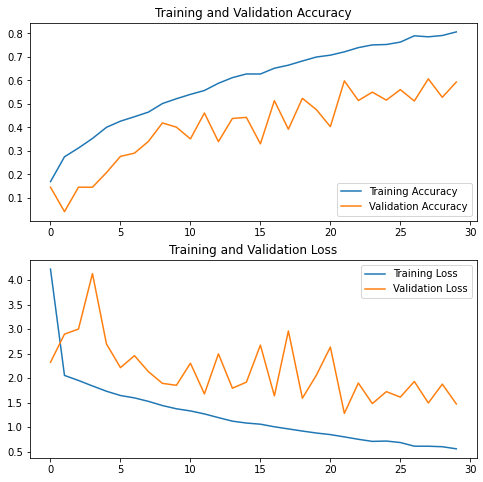

In [64]:
train_result = model.evaluate(train_dataset)
val_result = model.evaluate(val_dataset)
print('Train Acc:', train_result[1])
print('Test Acc:', val_result[1])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# prediction

In [ ]:
prediction = model.predict(test_x)

In [ ]:
train_y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)